In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


from torchsummary import summary
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage import io

%matplotlib inline

In [3]:
vocabulary = ["京", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "皖", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
"琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A",
"B", "C", "D", "E", "F", "G", "H", "J", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "U", "V", "W", "X",
"Y", "Z","港","学","使","警","澳","挂","军","北","南","广","沈","兰","成","济","海","民","航","空", ""]

# model

In [4]:
class Model(nn.Module):
    
    '''
    [1, 3, 160, 40]
    [1, 32, 80, 20]
    [1, 64, 40, 10]
    [1, 128, 20, 5]
    [1, 256, 20, 1]

    [1, 1024, 20, 1]
    [1, 1024, 20, 1]

    [1, 84, 20, 1]
    [1, 84, 20, 1]
    '''
    
    def __init__(self):
        super().__init__()
        
        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.relu0 = nn.ReLU()
        self.pool0 = nn.MaxPool2d(2, stride=2)
        
        self.conv1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2)
        
        self.conv2d_1 = nn.Conv2d(128, 256, (1,5), stride=1)
        self.batch_normalization_1 = nn.BatchNorm2d(256)
        self.activation_1 = nn.ReLU()
        
        # --------------------
        
        self.conv2d_2 = nn.Conv2d(256, 256, (7,1), stride=1, padding=(3,0))
        self.batch_normalization_2 = nn.BatchNorm2d(256)
        self.activation_2 = nn.ReLU()
        
        self.conv2d_3 = nn.Conv2d(256, 256, (5,1), stride=1, padding=(2,0))
        self.batch_normalization_3 = nn.BatchNorm2d(256)
        self.activation_3 = nn.ReLU()
        
        self.conv2d_4 = nn.Conv2d(256, 256, (3,1), stride=1, padding=(1,0))
        self.batch_normalization_4 = nn.BatchNorm2d(256)
        self.activation_4 = nn.ReLU()
        
        self.conv2d_5 = nn.Conv2d(256, 256, (1,1), stride=1)
        self.batch_normalization_5 = nn.BatchNorm2d(256)
        self.activation_5 = nn.ReLU()
        
        # -----------------
        
        self.conv_1024_11 = nn.Conv2d(1024, 1024, 1, stride=1)
        self.batch_normalization_6 = nn.BatchNorm2d(1024)
        self.activation_6 = nn.ReLU()
        
        self.conv_class_11 = nn.Conv2d(1024, 84, 1, stride=1)
        
    def forward(self, x):
        x = self.pool0(self.relu0(self.bn0(self.conv0(x))))
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.activation_1(self.batch_normalization_1(self.conv2d_1(x)))
        
        x2 = self.activation_2(self.batch_normalization_2(self.conv2d_2(x)))
        x3 = self.activation_3(self.batch_normalization_3(self.conv2d_3(x)))
        x4 = self.activation_4(self.batch_normalization_4(self.conv2d_4(x)))
        x5 = self.activation_5(self.batch_normalization_5(self.conv2d_5(x)))
        
        x = torch.cat([x2, x3, x4, x5], dim=1)
        
        x = self.activation_6(self.batch_normalization_6(self.conv_1024_11(x)))
        x = self.conv_class_11(x)
        x = torch.softmax(x, dim=1)
        
        return x

# dataset

In [5]:
class CarnumberDataset(Dataset):

    def __init__(self, data_dir):
        files = []
        for d in os.listdir(data_dir):
            for d2 in os.listdir(os.path.join(data_dir, d)):
                files.append(os.path.join(data_dir, d, d2))
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        image = io.imread(img_name)
        image = cv2.resize(image, (160,40)).transpose((2,1,0))
        
        text = os.path.basename(img_name).split('.')[0]
        carnumber = np.zeros((len(text)), dtype=np.long)
        for i, char in enumerate(text):
            carnumber[i] = vocabulary.index(char)

        return image, carnumber

In [6]:
data_dir_train = r'generateCarPlate\gen_res'
dataset_train = CarnumberDataset(data_dir_train)
dataloader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=0, drop_last=True)

In [7]:
data_dir_val = r'generateCarPlate\gen_res_val'
dataset_val = CarnumberDataset(data_dir_val)
dataloader_val = DataLoader(dataset_val, batch_size=4, shuffle=True, num_workers=0, drop_last=True)

In [8]:
def remove_connective_duplicate(src):
    last = None
    out = []
    for c in src.tolist():
        if last is None or last != c:
            last = c
            out.append(c)
    
    return np.array(out)

def decode(output):
    return ''.join(list(map(lambda i: vocabulary[i], output)))

def decode_prob(prob):
    return decode(remove_connective_duplicate(prob.argmax(axis=0)))

In [9]:
dataset_train[0][1].tolist()

[0, 42, 33, 54, 60, 58, 31]

In [10]:
dataset_val[0][1].tolist()

[0, 41, 36, 52, 59, 40, 37]

# train

In [11]:
model = Model()

In [39]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [40]:
criterion = nn.CTCLoss(blank=len(vocabulary)-1)

In [ ]:
model = model.train()

loss_history = []
for epoch in range(10):
    pbar = tqdm(dataloader_train)
    for batch_image, batch_carnumber in pbar:
        batch_image =  batch_image.float()
        batch_output = model(batch_image).squeeze()
        loss = criterion(batch_output.permute(2,0,1).log(), 
                         batch_carnumber, 
                         torch.tensor([batch_output.shape[2]]*batch_output.shape[0]), 
                         torch.tensor([batch_carnumber.shape[1]]*batch_carnumber.shape[0]))

        pbar.set_description(f'epoch {epoch}, loss:{loss.item():.4f}')
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

torch.save(model, 'model-lastest.pth')

In [47]:
model = model.eval()

correct = 0
for sample in tqdm(dataset_val):
    sample_image = sample[0]
    sample_carnumber = sample[1]
    output = decode_prob(model(torch.tensor(sample_image[np.newaxis,...]).float())[0].squeeze().detach().numpy())
    truth = decode(sample_carnumber)
    
    if output == truth:
        correct += 1
        
print(correct/len(dataset_val))

100%|██████████████████████████████████████████████████████████████████████████████| 3099/3099 [00:47<00:00, 65.72it/s]

0.6179412713778638


# test

In [52]:
#model = torch.load('model-lastest.pth')

In [1]:
def eval(file):
    image = io.imread()
    plt.imshow(image)
    image = cv2.resize(image, (160,40)).transpose((2,1,0))
    output = model(torch.tensor(image[np.newaxis,...]).float())[0].squeeze().detach().numpy()
    return decode_prob(output)

'粤SB11C8'

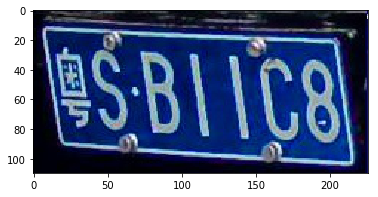

In [53]:
eval('a.jpg')

'川N3N829'

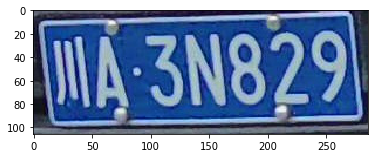

In [56]:
eval('b.jpg')

'粤QT9048'

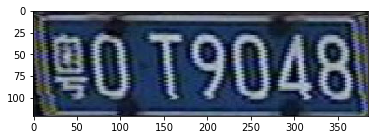

In [58]:
eval('c.jpg')